In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive',force_remount=True)

Mounted at /content/MyDrive


In [ ]:
%cd "/content/MyDrive/MyDrive"


/content/MyDrive/MyDrive


In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.autograd import Function
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080 Ti'

In [76]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

In [77]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders to load the data in batches during training and testing
batch_size = 256
mnist_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


image size torch.Size([256, 1, 28, 28])
label size torch.Size([256])


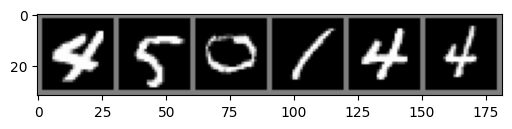

In [78]:
# let's have a look at the dataset
def imshow(img):
    img = img/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(mnist_train_loader)
images, labels = next(dataiter)

print("image size",images.shape)
print("label size",labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:6]))

In [79]:
###### sperate lables

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class GRL_Model(nn.Module):
    def __init__(self, grl=False):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 48, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.classifier = nn.Sequential(
        nn.Linear(48 * 4 * 4, 100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
        )
        
        self.domain_clf = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

        self.grl = grl

    def forward(self, x, alpha):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        class_op = self.classifier(features)
        if self.grl:
            rev_feature = GradientReversalFunction.apply(features, alpha)
            domain_op = self.domain_clf(rev_feature)
            return class_op, domain_op
        return class_op


In [33]:
#@title Default title text
# model= baseline().to(device)
# train(model, train_loader,10)

In [99]:
##new edit
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 1e-3
source_model = GRL_Model().to(device)

#if os.path.exists(SOURCE_MODEL_PATH):
source_model.load_state_dict(torch.load("source_model.pt"))

source_optim = optim.Adam(source_model.parameters(), lr=LR)
source_criterion = nn.CrossEntropyLoss()



In [100]:
# #new edit:
def train(epoch, model, train_loader, criterion, optimizer):
    train_loss = 0
    model.train()
    tqdm_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1} ', total=int(len(train_loader)))
    for idx, (images, labels) in enumerate(tqdm_bar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, 0.)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(loss.item())
        outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)

        train_acc = accuracy_score(labels.cpu(), outputs.cpu())
        train_accs.append(train_acc)
        tqdm_bar.set_postfix(train_loss=(train_loss/(idx+1)), train_accuracy=train_acc)
        train_counter.append(idx * BATCH_SIZE + images.size(0) + epoch * len(train_loader.dataset))

def test(model, test_loader, criterion, name="source"):
  test_loss, test_acc = 0, 0
  model.eval()
  tqdm_bar = tqdm(test_loader, desc=f"Testing ", total=int(len(test_loader)))
  for idx, (images, labels) in enumerate(tqdm_bar):
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():
          if name == "no1":
              outputs, _ = model(images, 1.)
          else:
              outputs = model(images, 0.)
          loss = criterion(outputs, labels)
      test_loss += loss.item()
      outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)
          
      test_acc_b = accuracy_score(labels.cpu(), outputs.cpu())
      test_acc += test_acc_b
      tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_acc_b)
  test_losses.append(test_loss/len(test_loader))
  test_accs.append(test_acc/len(test_loader))
 

  if np.argmax(test_accs) == len(test_accs) - 1:
      torch.save(model.state_dict(), f"{name}_model.pt")

In [101]:
train_losses, train_accs, train_counter = [], [], []
test_losses, test_accs = [], []
test_counter = [idx * len(mnist_train_loader.dataset) for idx in range(0, N_EPOCHS + 1)]

In [102]:

for epoch in range(N_EPOCHS):
    train(epoch, source_model, mnist_train_loader, source_criterion, source_optim)
    test(source_model, mnist_test_loader, source_criterion, name="source")

Testing : 100%|██████████| 40/40 [00:01<00:00, 26.55it/s, test_accuracy=1, test_loss=0.0308]


In [103]:
import plotly.graph_objects as go
def plot_losses():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_counter, y=train_losses, mode='lines', name='Train loss'))
    fig.add_trace(go.Scatter(x=test_counter, y=test_losses, marker_symbol='star-diamond', 
                            marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test loss'))
    fig.update_layout(
        width=700, height=300,
        title="Train vs. Test Loss",
        xaxis_title="Number of training examples seen",
        yaxis_title="Negative Log Likelihood loss"),
    fig.show()

plot_losses() 

In [104]:
def plot_accs():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_counter, y=train_accs, mode='lines', name='Train Accuracy'))
    fig.add_trace(go.Scatter(x=test_counter, y=test_accs, marker_symbol='star-diamond', 
                            marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Accuracy'))
    fig.update_layout(
        width=700, height=300,
        title="Train vs. Test Accuracy",
        xaxis_title="Number of training examples seen",
        yaxis_title="Accuracy")
    fig.show()

plot_accs()

In [83]:
#@title Default title text
# def test(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device).long()
#             output = model(data)
#             _, predicted = torch.max(output.data, 1)
#             total += target.size(0)
#             correct += (predicted == target).sum().item()
            
#     print(f"Test accuracy: {100*correct/total:.2f}%")

In [84]:
# test(model, test_loader)

In [85]:
# !tar -xzf mnist_m.tar.gz -C new_mnistm/

In [105]:
class MnistMDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data = []
        self.targets = []

        if self.split == 'train':
            images_dir = root_dir + '/mnist_m_train'
            labels_file = root_dir + '/mnist_m_train_labels.txt'
        elif self.split == 'test':
            images_dir = root_dir + '/mnist_m_test'
            labels_file = root_dir + '/mnist_m_test_labels.txt'
        else:
            raise ValueError("Invalid split. Must be 'train' or 'test'")

        with open(labels_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img_file, label = line.strip().split()
                self.data.append(images_dir + '/' + img_file)
                self.targets.append(int(label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.open(self.data[index]).convert('RGB')
        target = self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target




In [106]:
# Set the path to the MNIST-M dataset
data_dir = 'new_mnistm/mnist_m'

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the training and test datasets
mnistm_train_dataset = MnistMDataset(data_dir, split='train', transform=transform)
mnistm_test_dataset = MnistMDataset(data_dir, split='test', transform=transform)

# Create the data loaders
mnistm_train_loader = torch.utils.data.DataLoader(mnistm_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
mnistm_test_loader = torch.utils.data.DataLoader(mnistm_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


image size torch.Size([64, 1, 28, 28])
label size torch.Size([64])


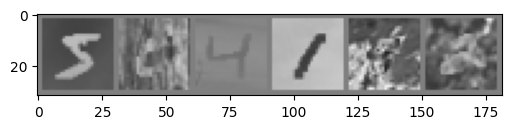

In [107]:
# get some random training images
dataiter_m = iter(mnistm_train_loader)
images, labels = next(dataiter_m)

print("image size",images.shape)
print("label size",labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:6]))

In [108]:
test(source_model, mnistm_test_loader, source_criterion, name="target")

Testing : 100%|██████████| 141/141 [00:02<00:00, 64.50it/s, test_accuracy=0.585, test_loss=2.33]


#2

In [129]:
target_model = GRL_Model().to(device)

In [130]:
train_losses, train_accs, train_counter = [], [], []
test_losses, test_accs = [], []
test_counter = [idx * len(train_loader.dataset) for idx in range(0, N_EPOCHS + 1)]

for epoch in range(N_EPOCHS):
    train(epoch, target_model, mnistm_train_loader, source_criterion, source_optim)
    test(target_model, mnistm_test_loader, source_criterion, name="target")

Testing : 100%|██████████| 141/141 [00:01<00:00, 79.49it/s, test_accuracy=0.0976, test_loss=2.31] 


In [131]:
plot_accs()
plot_losses()

In [ ]:
#test(source_model, mnistm_test_loader, source_criterion, name="target")

Test accuracy: 86.73%


#3 :: GRL

In [109]:
grl_model= GRL_Model(grl=True).to(device)
grl_model.load_state_dict(torch.load("source_model.pt"))#, map_location=device))

<All keys matched successfully>

In [110]:
half_batch_size = BATCH_SIZE // 2
source_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=half_batch_size, shuffle=True)
source_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create the data loaders
target_train_loader = torch.utils.data.DataLoader(mnistm_train_dataset, batch_size=half_batch_size, shuffle=True, num_workers=2)
target_test_loader = torch.utils.data.DataLoader(mnistm_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#working method


In [112]:
N_EPOCHS = 10
LAMBDA = 10
LR_0 = 0.01
BETA = 0.75

def grl_train(model, strain_loader, ttrain_loader, stest_loader, ttest_loader, optimizer):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    min_val_loss = np.Inf
    clf_criterion = nn.CrossEntropyLoss()
    dom_clf_criterion = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    for epoch in range(N_EPOCHS):
        model.train()
        len_dataloader = min(len(strain_loader), len(ttrain_loader))
        pbar = tqdm(total=len_dataloader, leave=True, desc=f"Training Epoch {epoch}")
        curr_tloss, curr_vloss = 0., 0.

        source_iter, target_iter = iter(strain_loader), iter(ttrain_loader)

        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (N_EPOCHS * len_dataloader)
            alpha = (2. / (1. + np.exp(-LAMBDA * p))) - 1
            for g in optimizer.param_groups:
                g["lr"] = LR_0 / np.power((1 + LAMBDA * p), BETA)
    
            source_data = source_data.to(device)
            source_labels = source_labels.to(device)
            target_data = target_data.to(device)
            target_labels = target_labels.to(device)
            source_domain_labels = torch.zeros(source_data.shape[0]).to(device)
            target_domain_labels = torch.ones(target_data.shape[0]).to(device)

            optimizer.zero_grad()

            # Predictions
            source_classes, source_domains = model(source_data, alpha)
            _, target_domains = model(target_data, alpha)

            # Losses
            label_loss = clf_criterion(source_classes, source_labels)
            source_domain_loss = dom_clf_criterion(sigmoid(
                source_domains[:, 0]), source_domain_labels)
            target_domain_loss = dom_clf_criterion(sigmoid(
                target_domains[:, 0]), target_domain_labels)
            
            loss = label_loss + source_domain_loss + target_domain_loss
            loss.backward()
            optimizer.step()
            curr_tloss += loss.cpu().data.item()
            
            # Accuracies
            y_true = target_domain_labels.cpu().detach().numpy()
            y_pred = sigmoid(target_domains[:, 0]).cpu().detach().numpy()
            y_pred = (y_pred >= 0.5) * 1.0
            domain_acc = accuracy_score(y_true, y_pred)

            y_true = source_labels.cpu().detach().numpy()
            y_pred = source_classes.max(1)[1].cpu().detach().numpy()
            label_acc = accuracy_score(y_true, y_pred)

            pbar.update(1)
            pbar.set_postfix(train_loss=loss.item(), domain_accuracy=domain_acc, 
                label_accuracy=label_acc)
            train_accs.append([domain_acc, label_acc])
            
        curr_tloss /= len_dataloader
        train_losses.append(curr_tloss)  
        
        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(stest_loader), len(ttest_loader))
            source_val_iter, target_val_iter = iter(stest_loader), iter(ttest_loader)
            
            for _ in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()

                source_val_data = source_val_data.to(device)
                source_val_labels = source_val_labels.to(device)
                target_val_data = target_val_data.to(device)
                target_val_labels = target_val_labels.to(device)
                
                source_pred_labels, _ = model(source_val_data, alpha)
                target_pred_labels, _ = model(target_val_data, alpha)

                source_label_loss = clf_criterion(source_pred_labels, source_val_labels)
                target_label_loss = clf_criterion(target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                curr_vloss += loss.cpu().data.item()

                source_acc = accuracy_score(source_val_labels.cpu().detach().numpy(), 
                                source_pred_labels.max(1)[1].cpu().detach().numpy())
                target_acc = accuracy_score(target_val_labels.cpu().detach().numpy(), 
                                target_pred_labels.max(1)[1].cpu().detach().numpy())

                val_acc = round((source_acc + target_acc) / 2, 3)
                val_accs.append(val_acc)
                
            curr_vloss /= len_val_dataloader
            val_losses.append(curr_vloss)

        if curr_vloss < min_val_loss:
            min_val_loss = curr_vloss
            torch.save(model.state_dict(), "grl_model.pt")

        pbar.set_postfix(train_loss=curr_tloss, domain_accuracy=domain_acc, 
            label_accuracy=label_acc, val_loss=curr_vloss, val_accuracy=val_acc)
        pbar.refresh()
        pbar.close()
    return train_losses, val_losses, train_accs, val_accs

In [113]:
optimizer = torch.optim.SGD(grl_model.parameters(), lr=LR, momentum=0.9)

train_losses, test_losses, train_accs, val_accs = grl_train(grl_model, source_train_loader, target_train_loader, 
                                                        source_test_loader, target_test_loader, optimizer)

Training Epoch 9: 100%|██████████| 1844/1844 [00:37<00:00, 49.40it/s, domain_accuracy=0.8, label_accuracy=1, train_loss=1.3, val_accuracy=0.769, val_loss=2.55]


In [122]:
test_losses, test_accs = [], []
target_criterion = nn.CrossEntropyLoss()
grl_model.load_state_dict(torch.load("grl_model.pt"))
test(grl_model, mnistm_test_loader, target_criterion, name="no1")
print(f"GRL model accuracy on Mnist: {np.max(test_accs):.3f}")

Testing : 100%|██████████| 141/141 [00:02<00:00, 59.11it/s, test_accuracy=0.61, test_loss=1.6]


GRL model accuracy on Mnist: 0.501


In [123]:
def evaluate(model, loader):
    preds_labels = []
    preds_domains = []
    gt_labels = []
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            pred_labels, pred_domains = model(data, 1.)
            pred_domains = np.round(np.array(pred_domains.cpu().detach()))
            preds_domains.append(pred_domains)
                
            softmax = torch.nn.Softmax()
            pred_labels = np.argmax(np.array(softmax(pred_labels.cpu().detach())), axis = 1)
            
            preds_labels.extend(pred_labels)
            gt_labels.extend(target.cpu())
    
    preds_labels = np.array(preds_labels)
    gt_labels = np.array(gt_labels)  
    return preds_labels, gt_labels

In [124]:
grl_preds, grl_gt = evaluate(grl_model, mnistm_test_loader)

print("Class Label Report")
print(classification_report(grl_preds, grl_gt))

print("Confusion Matrix")
confusion_matrix(grl_preds, grl_gt)

/tmp/ipykernel_19374/2070155143.py:15: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Class Label Report
              precision    recall  f1-score   support

           0       0.55      0.60      0.57       803
           1       0.55      0.58      0.56       955
           2       0.36      0.65      0.46       512
           3       0.44      0.64      0.52       624
           4       0.39      0.81      0.52       424
           5       0.36      0.80      0.50       367
           6       0.57      0.72      0.64       683
           7       0.59      0.52      0.55      1034
           8       0.65      0.25      0.36      2254
           9       0.55      0.38      0.45      1345

    accuracy                           0.50      9001
   macro avg       0.50      0.59      0.51      9001
weighted avg       0.55      0.50      0.49      9001

Confusion Matrix


array([[482,  34,  63,  21,  36,  13,  78,  18,  35,  23],
       [ 42, 554,  76,  40,  71,  17,  25,  47,  49,  34],
       [ 13,  21, 335,  28,  22,  10,  22,  36,  11,  14],
       [ 29,  19,  54, 399,  46,  26,  23,  12,   5,  11],
       [  7,  17,   9,   0, 343,   4,   5,   5,   9,  25],
       [  4,   3,   7,  13,  16, 292,  11,   5,   7,   9],
       [ 37,  18,   8,  11,  23,  38, 490,   5,  38,  15],
       [ 21, 128,  48,  42,  61,  30,  13, 539,  56,  96],
       [152, 151, 257, 225, 164, 247, 165, 136, 570, 187],
       [ 91,  71,  76, 129, 108, 130,  24, 111, 100, 505]])

# Target Only Model

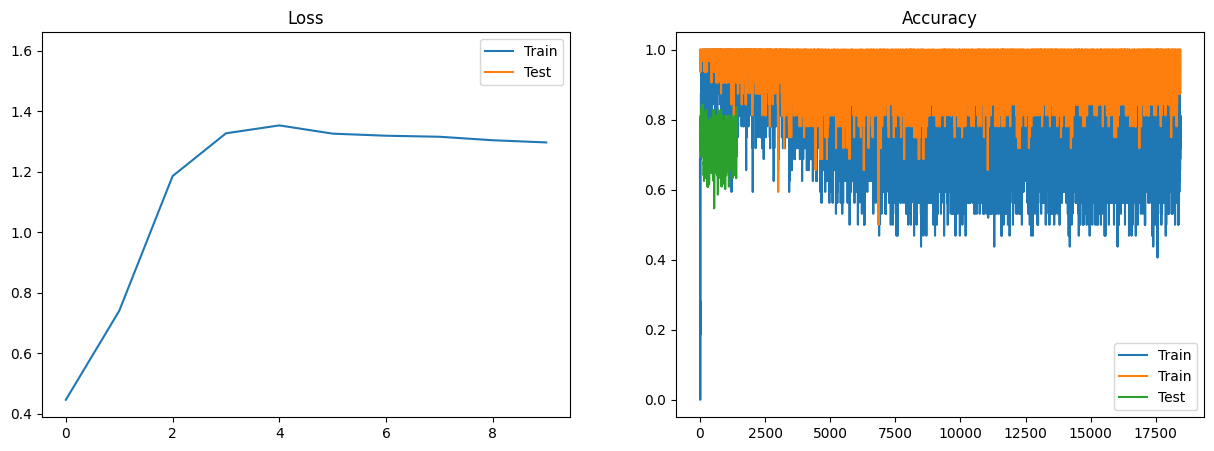

In [125]:
# plot loss curves using train_losses, test_losses

f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label="Train")
ax[0].plot(test_losses, label="Test")
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(train_accs, label="Train")
ax[1].plot(val_accs, label="Test")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

#plots

In [126]:


def tsne_features(model, sloader, tloader, subset=1500):
    model.eval()
    model = model.to(device)
    sfeats, tfeats = [], []
    
    for _, (data, _) in enumerate(sloader):
        data = data.to(device)
        feats = model.feature_extractor(data).cpu().detach().numpy()
        sfeats.append(feats)

    for _, (data, _) in enumerate(tloader):
        data = data.to(device)
        feats = model.feature_extractor(data).cpu().detach().numpy()
        tfeats.append(feats)

    sfeats = np.vstack(np.array(sfeats))[:subset, :]
    tfeats = np.vstack(np.array(tfeats))[:subset, :]

    sfeats = sfeats.reshape(sfeats.shape[0], -1)
    tfeats = tfeats.reshape(tfeats.shape[0], -1)

    tsne = TSNE(n_components=2, random_state=42, init="pca")
    tsne_proj_source = tsne.fit_transform(sfeats)
    tsne_proj_target = tsne.fit_transform(tfeats)
    return tsne_proj_source, tsne_proj_target
    



In [127]:


s_sproj, s_tproj = tsne_features(source_model, mnist_test_loader, mnistm_test_loader)
#t_sproj, t_tproj = tsne_features(target_model, test_loader, target_test_loader)
g_sproj, g_tproj = tsne_features(grl_model, mnist_test_loader, mnistm_test_loader)



/tmp/ipykernel_19374/3224350765.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/tmp/ipykernel_19374/3224350765.py:17: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/home/abhiroop.talasila/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/abhiroop.talasila/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal t

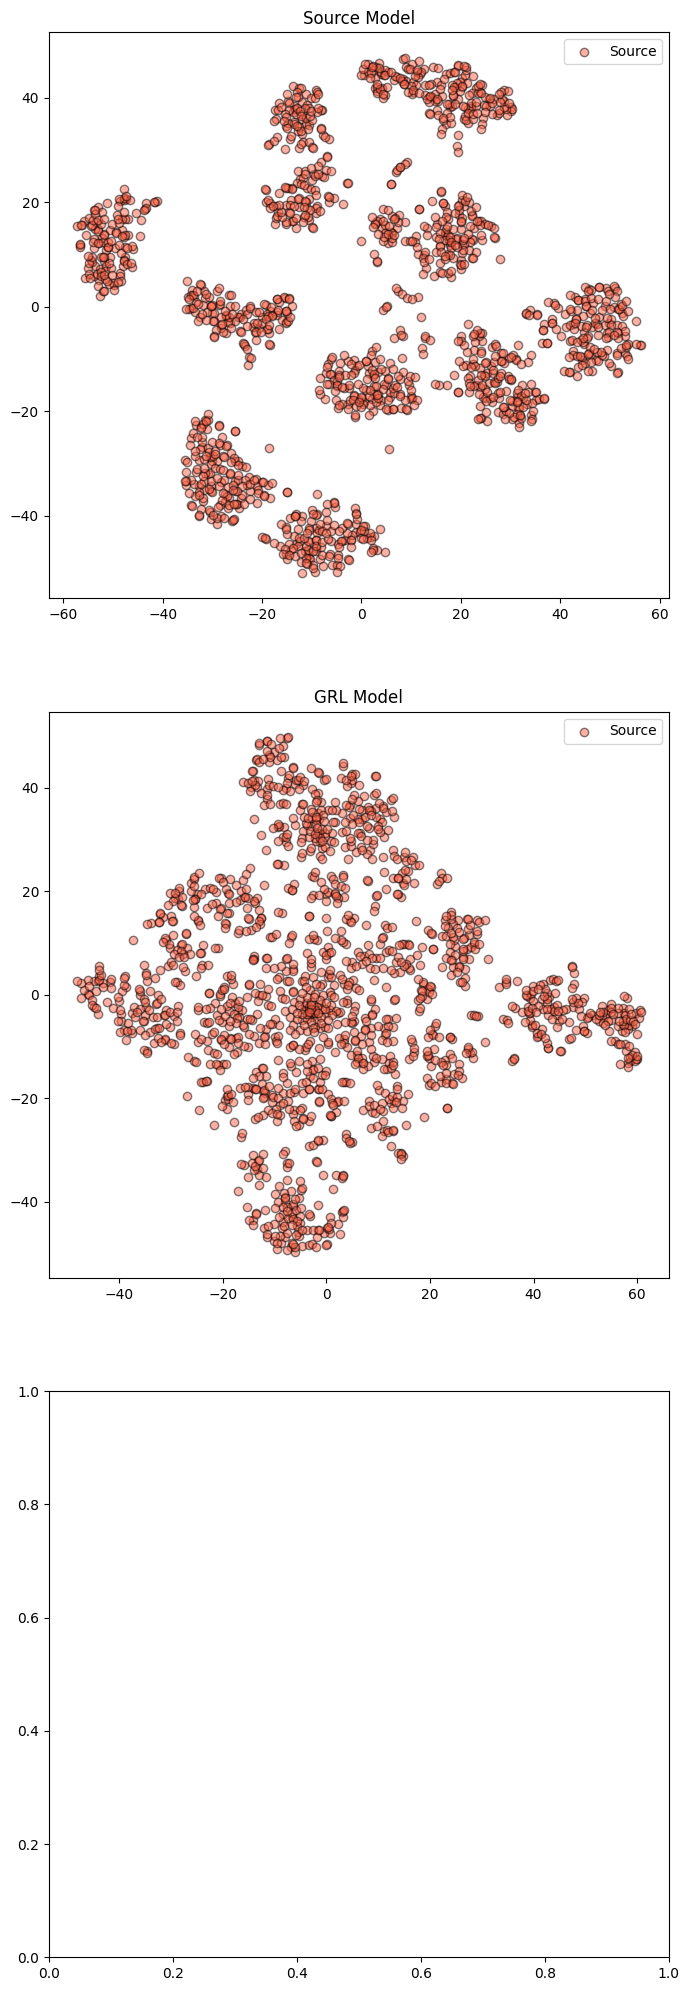

In [128]:

from matplotlib import cm
f, ax = plt.subplots(3, 1, figsize=(8, 25))
cmap = cm.get_cmap("tab20")
s_projs = [s_sproj, g_sproj]
#t_projs = [s_tproj, t_tproj, g_tproj]

for i, title in zip([0, 1], ["Source", "GRL"]):
    ax[i].scatter(s_projs[i][:, 0], s_projs[i][:, 1], c="tomato", label="Source", alpha=0.5, edgecolors='black')
   # ax[i].scatter(t_projs[i][:, 0], t_projs[i][:, 1], c="skyblue", label="Target", alpha=0.5, edgecolors='black')
    ax[i].set_title(f"{title} Model")
    ax[i].legend()
plt.show()

